In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, average_precision_score
from tensorflow.keras.models import load_model


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [17]:
base_dir = "NEU - c пилингом"
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'valid')
all_dirs = [train_dir, test_dir, validation_dir]

In [18]:
datagen_for_defects = ImageDataGenerator()
generator_for_defects = datagen_for_defects.flow_from_directory(
    train_dir,
    target_size = (200, 200),
    batch_size = 1,
    class_mode = "categorical",
    shuffle = False # не перемешивать
)
defects = list(generator_for_defects.class_indices.keys())
defects


Found 5040 images belonging to 7 classes.


['Crazing', 'Inclusion', 'Patches', 'Peeling', 'Pitted', 'Rolled', 'Scratches']

In [19]:
img_height = 200
img_width = 200
batch_size = 32

In [20]:
train_datagen = ImageDataGenerator(
    rescale= 1.0 / 255,  # Нормализация (перевод в диапазон 0-1)
    rotation_range = 20,  # Вращение изображений на ±20 градусов
    fill_mode = "nearest", # заполняет пустые области ближайшими пикселями
    # width_shift_range = 0.1,  # Смещение по ширине (20%) - лучше не использовать, так как у нас есть дефекты на краях 
    # height_shift_range = 0.1,  # Смещение по высоте (20%)
    horizontal_flip = True,  # Отражение по горизонтали
)

val_datagen = ImageDataGenerator(rescale = 1.0 / 255) # только нормализуем

In [21]:
classes = ['crazing',
        'inclusion',
        'patches',
        'peeling',
        'pitted',
        'rolled',
        'scratches'
        ]

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width), # высота, ширина
    batch_size = batch_size,
    class_mode = "categorical",
    classes = classes,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = "categorical",
    classes = classes
)
test_datagen = ImageDataGenerator(rescale = 1.0 / 255) 
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_width),
    batch_size = 1,
    class_mode = "categorical",
    shuffle = False, # не перемешивать
    classes = classes
)

Found 5040 images belonging to 7 classes.
Found 210 images belonging to 7 classes.
Found 210 images belonging to 7 classes.


Модель One-vs-All: Создаётся 6 отдельных бинарных классификаторов, каждый из которых обучается определять один конкретный класс против всех остальных. Например, первая модель обучается классифицировать "Crazing" vs. "не Crazing", вторая — "Inclusion" vs. "не Inclusion" и так далее. Итоговый предсказанный класс определяется на основе вероятностных выходов всех моделей

In [22]:
def create_model(class_name):
    model = Sequential([
        Conv2D(32, (4, 4), activation='relu', input_shape=(img_height, img_width, 3)),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(2, 2)
    ])


    if (class_name == "inclusion" or class_name == "pitted" or class_name == "scratches" or class_name == "peeling"):
        model.add(Conv2D(512, (2, 2), activation='relu'))
        model.add(MaxPooling2D(2, 2))


    epochs = 20
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model, epochs

In [9]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') is not None and logs.get('val_accuracy') > 0.99:
            print("\nстоп")
            self.model.stop_training = True

In [10]:
callbacks = myCallback()
models = {}
def fit_model(classes, needed_classes):
    for i, class_name in enumerate(classes):
        if (class_name in needed_classes):
            print(f"Обучение модели для класса: {class_name}")

            # Преобразуем метки в бинарные (0 или 1)
            def binary_labels(generator, class_index):
                while True:
                    X, y = next(generator)
                    y_binary = (y[:, class_index] == 1).astype(int)  # Преобразуем one-hot в бинарные метки
                    yield X, y_binary

            train_gen_binary = binary_labels(train_generator, i) # бинарный генератор
            val_gen_binary = binary_labels(val_generator, i)

            model, epochs = create_model(class_name)
            model.fit(
                train_gen_binary,
                steps_per_epoch=len(train_generator), # шагов в эпохе столько же, сколько в оригинальном генераторе
                validation_data=val_gen_binary,
                validation_steps=len(val_generator),
                epochs = epochs,
                verbose = 2,
                # callbacks=[lr_scheduler] #!
                callbacks=[callbacks]
            )
            models[class_name] = model
            # return model
            model.save(f"models/model_{class_name}.keras")



In [11]:
# needed_classes = ["peeling"]
# fit_model(classes, needed_classes)

In [23]:
x_test = []
y_test = []

for i in range(len(test_generator)):
    img, label = next(test_generator)
    x_test.append(img[0])  # Берем изображение (размер: (img_size, img_size, 3))
    y_test.append(label[0])  # Берем метку

x_test = np.array(x_test)
y_test = np.array(y_test)
true_classes = np.argmax(y_test, axis=1)  # Истинные метки (массив индексов классов для каждого изображения)
target_labels = list(test_generator.class_indices.keys())
num_classes = len(classes)

print("Форма x_test:", x_test.shape)  # Должно быть (N, img_size, img_size, 3)
print("Форма y_test:", y_test.shape)  # Должно быть (N, 6) — One-Hot Encoding
print(target_labels)

Форма x_test: (210, 200, 200, 3)
Форма y_test: (210, 7)
['crazing', 'inclusion', 'patches', 'peeling', 'pitted', 'rolled', 'scratches']


In [24]:
predictions = np.zeros((len(x_test), num_classes))  # Матрица предсказанных вероятностей
loaded_models = [load_model(f"6_classes_97_NEU2 peeling/model_{i}.keras") for i in classes]

for i, class_name in enumerate(classes):
    model = loaded_models[i]
    predictions[:, i] = model.predict(x_test).flatten()  # Вероятность принадлежности классу

# Определяем предсказанный класс как тот, у которого максимальная вероятность
predicted_classes = np.argmax(predictions, axis=1)

class_accuracy = []
for cls in range(len(classes)):
    mask = true_classes == cls
    print(f"class: {classes[cls]}, точность: {accuracy_score(true_classes[mask], predicted_classes[mask])}")
    class_accuracy.append(accuracy_score(true_classes[mask], predicted_classes[mask])) 


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
class: crazing, точность: 1.0
class: inclusion, точность: 0.9333333333333333
class: patches, точность: 1.0
class: peeling, точность: 0.9
class: pitted, точность: 0.9666666666666667
class: rolled, точность: 1.0
class: scratches, точность: 1.0


In [17]:
loaded_models[5].summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 197, 197, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 98, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 46, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,489,541 (28.57 MB)

 Trainable params: 2,496,513 (9.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,993,028 (19.05 MB)

In [25]:
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-оценка: {f1 * 100:.2f}%")

Accuracy: 97.14%
Precision: 97.24%
Recall: 97.14%
F1-оценка: 97.12%


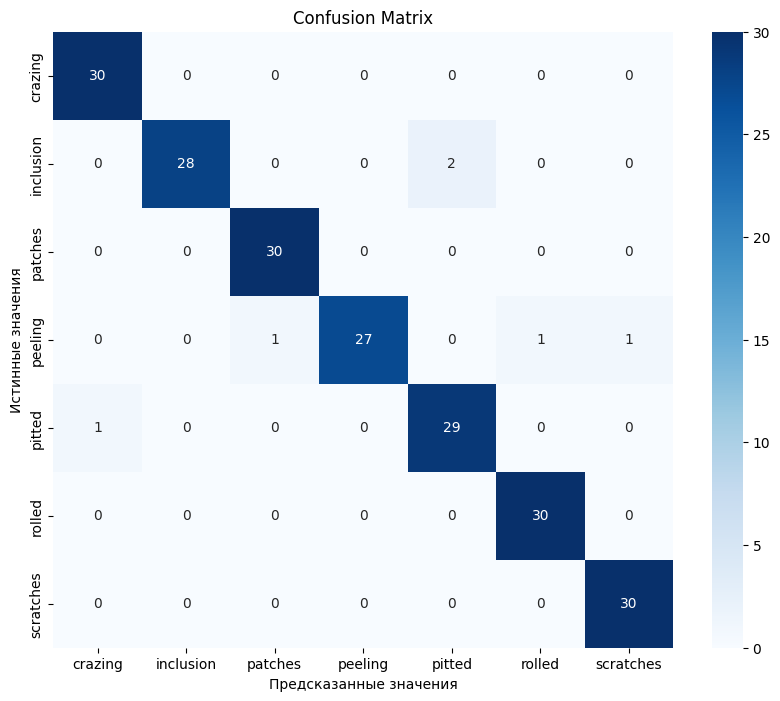

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Confusion Matrix')
plt.show()

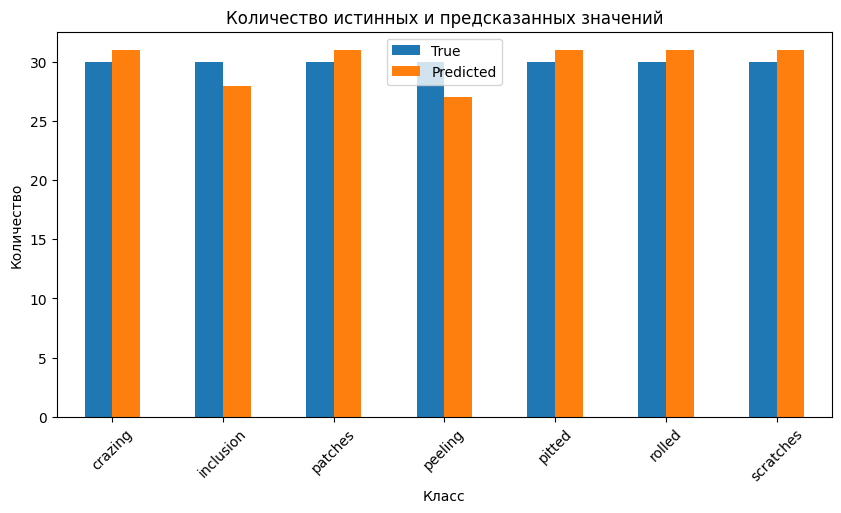

In [20]:
df = pd.DataFrame({
    'True': pd.Series(true_classes).value_counts(),
    'Predicted': pd.Series(predicted_classes).value_counts()
})
df.plot(kind='bar', figsize=(10, 5))
plt.title('Количество истинных и предсказанных значений')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.xticks(range(len(classes)), classes, rotation=45)
plt.show()

class: crazing, точность: 1.0
class: inclusion, точность: 0.9333333333333333
class: patches, точность: 1.0
class: peeling, точность: 0.9
class: pitted, точность: 0.9666666666666667
class: rolled, точность: 1.0
class: scratches, точность: 1.0


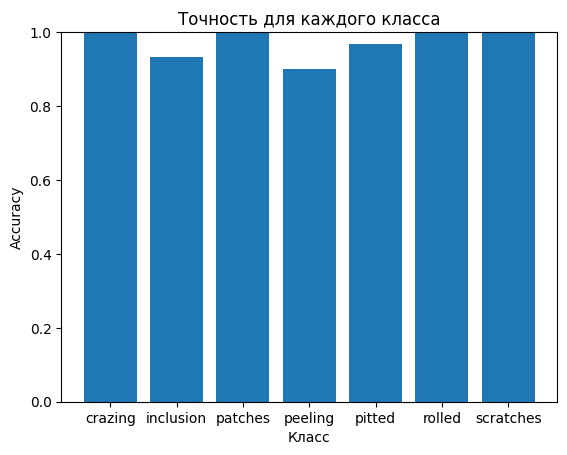

In [21]:
class_accuracy = []
for cls in range(len(classes)):
    mask = true_classes == cls
    print(f"class: {classes[cls]}, точность: {accuracy_score(true_classes[mask], predicted_classes[mask])}")
    class_accuracy.append(accuracy_score(true_classes[mask], predicted_classes[mask]))

plt.bar(classes, class_accuracy)
plt.title('Точность для каждого класса')
plt.xlabel('Класс')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

In [23]:
# from flask import Flask, render_template
# from werkzeug.serving import run_simple
# import json

# app = Flask(__name__)

# IMG_FOLDER = "static/images"
# os.makedirs(IMG_FOLDER, exist_ok=True)

# def save_images(x_test, predicted_classes, true_classes, target_labels):
#     label_to_index = {label: idx for idx, label in enumerate(target_labels)}
#     indices = np.arange(x_test.shape[0])
#     img_paths = []
    
#     for i, idx in enumerate(indices):
#         img_path = os.path.join(IMG_FOLDER, f"img_{i}.png")
#         plt.imsave(img_path, x_test[idx])
        
#         # Формируем путь для HTML (заменяем \ на /)
#         html_img_path = img_path.replace("\\", "/")

#         # Получаем вероятности для текущего изображения
#         probabilities = predictions[idx]

#         # Преобразуем вероятности в проценты
#         probabilities_percent = {label: f"{prob * 100:.2f}%" for label, prob in zip(target_labels, probabilities)}
        
#         probabilities_percent = dict(
#             sorted(probabilities_percent.items(), key=lambda item: float(item[1].rstrip('%')), reverse=True)
#         )
#         # predicted_class = np.argmax(probabilities)

#         probabilities_percent = probabilities_percent
        
#         pred_label = target_labels[predicted_classes[idx]]
#         true_label = target_labels[true_classes[idx]]
#         img_paths.append({
#             "path": html_img_path,  # Используем исправленный путь
#             "pred_label": pred_label,
#             "true_label": true_label,
#             "color": "#008000" if predicted_classes[idx] == true_classes[idx] else "#ff0000",
#             "probabilities": json.dumps(probabilities_percent)
#         })
    
#     return img_paths

# @app.route("/")
# def index():
#     # Здесь предполагается, что x_test, predicted_classes, true_classes, target_labels загружены
#     # target_labels = {0: "Crazing", 1: "Inclusion", 2: "Patches", 3: "Pitted", 4: "Rolled", 5: "Scratches"}  # Пример меток
#     img_data = save_images(x_test, predicted_classes, true_classes, target_labels)
#     return render_template("index.html", images=img_data)

# # if __name__ == "__main__":
# #     app.run(debug=True)

# run_simple('localhost', 5000, app)
